In [152]:
from __future__ import annotations
from scipy.stats import binom, beta
import numpy as np
from pydantic.dataclasses import dataclass
from pydantic import conint, validator
from enum import Enum
import matplotlib.pyplot as plt
# https://github.com/liguowang/dcon/blob/master/lib/DconModule/utils.py

class Genotype(Enum):
    HET="HET" #heterozygous
    HOM="HOM" #homozygous

@dataclass
class VariantPosition:
    total_depth: conint(ge=0)
    allele2_depth: conint(ge=0)
    variant_type: Genotype
    
    @validator('allele2_depth')
    def depth_validation(cls, v, values, **kwargs):
        if values["total_depth"] < v:
            raise ValueError('total_depth must be > alleles2_depth')
        return v
    
    def log_contam_probability(self, contam_level: float) -> float:
        """
        Estimate the log probabibily of a given contamination level
        
        :param float contam_level: A
        """
        if not (0 <= contam_level < 1):
            raise ValueError(f"Contamination level must be between 0 and 1: {contam_level}")
        
        if self.variant_type == Genotype.HOM:
            expected_allele2_fraction = contam_level 
            return binom.logpmf(
                k=self.allele2_depth, 
                n=self.total_depth, 
                p=expected_allele2_fraction
            )
        else:
            possible_expected_allele2_fractions = [
                (1-contam_level)  / 2, # low AF in ALT because of contam
                (1-contam_level), # this is when a HOM being called as HET because of contam
                (0.5 + contam_level), # this is when contam looks like ALT
            ]
            return max(
                binom.logpmf(
                    k=self.allele2_depth, 
                    n=self.total_depth, 
                    p=expected_allele2_fraction
                ) for expected_allele2_fraction in possible_expected_allele2_fractions
            )
        

def estimate_contamination(variant_positions: List[VariantPosition]) -> dict[float,float]:
    """
    Given a list of SNV position, we will calculate the likelihood at different contamination
    level
    
    :param List[VariantPosition] variant_positions: a list of VariantPosition object
    :return: a dictionary of contamination level and it's log likeliehood value
    :rtype: dicct[float, float]
    """
    possible_contamination_level = np.arange(500) / 1000
    result = {}
    
    for contam_level in possible_contamination_level:
        result[contam_level] = sum(
            variant_position.log_contam_probability(contam_level) 
            for variant_position in variant_positions
        )

    return result


def maximum_likelihood_contamination(variant_positions: List[VariantPosition]) -> float:
    """
    Given a list of SNV position, we will estimate the most probable contamination level
    
    :param List[VariantPosition] variant_positions: a list of VariantPosition object
    :return: a dictionary of contamination level and it's log likeliehood value
    :rtype: dicct[float, float]
    """    
    
    likelihoods = estimate_contamination(variant_positions)
    sorted_likelihoods = sorted(likelihoods.items(), key=lambda k: k[1]) # ascending sort
    return sorted_likelihoods[-1][0] # the key of the last item is the max likelihood

Simulating: 0.0; Estimated: 0.002
Simulating: 0.05; Estimated: 0.047
Simulating: 0.1; Estimated: 0.097
Simulating: 0.15000000000000002; Estimated: 0.147
Simulating: 0.2; Estimated: 0.194
Simulating: 0.25; Estimated: 0.245
Simulating: 0.30000000000000004; Estimated: 0.297
Simulating: 0.35000000000000003; Estimated: 0.342
Simulating: 0.4; Estimated: 0.398
Simulating: 0.45; Estimated: 0.446


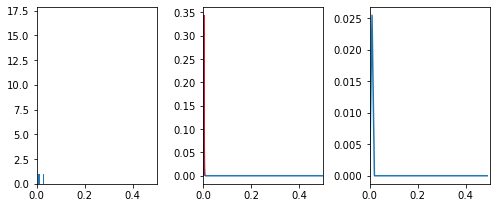

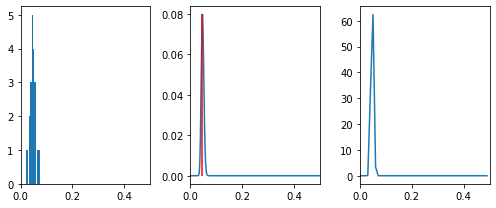

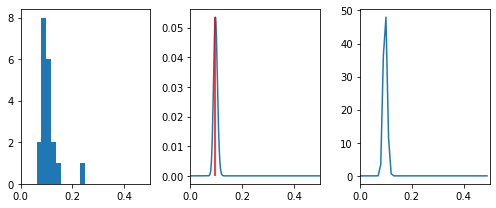

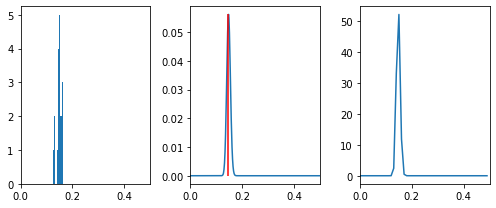

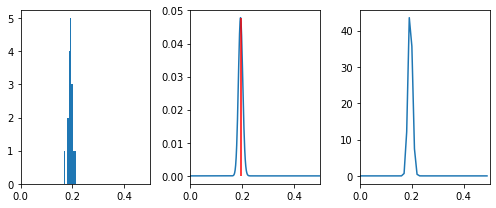

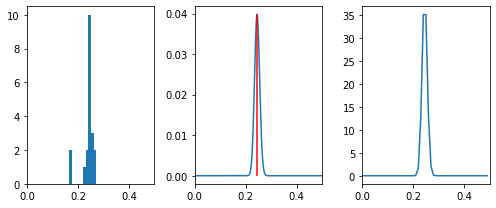

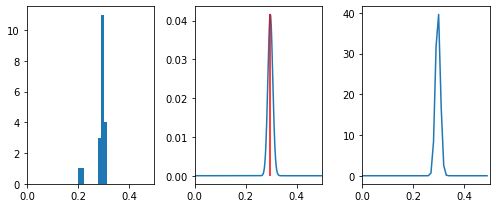

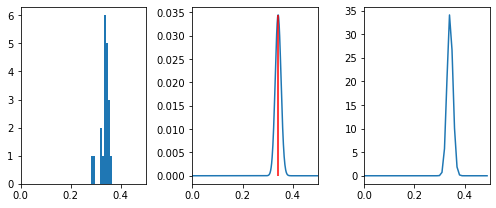

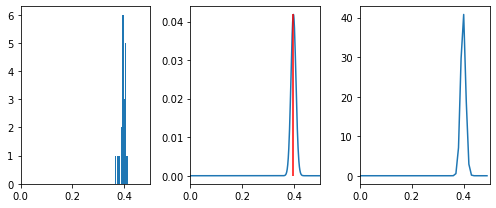

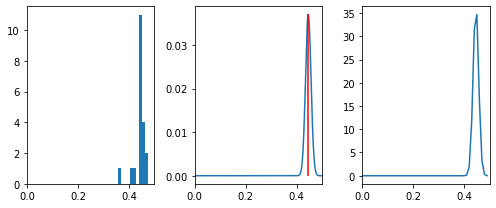

In [180]:
def plot_result(vp, dist, sorted_likelihoods):
    fig = plt.figure(figsize=(7,3))
    ax = fig.add_subplot(131)
    ax.hist([v.allele2_depth / v.total_depth for v in vp])
    ax.set_xlim(0,0.5)
    
    
    ax = fig.add_subplot(132)
    
    lik=np.exp(list(dist.values()))
    prob = lik/sum(lik)
    
    ax.plot(dist.keys(), prob)
    ax.vlines(
        x=sorted_likelihoods[-1][0], 
        ymin=0, 
        ymax=np.max(prob), 
        color='red'
    )
    ax.set_xlim(0,0.5)
    
    
    aa, bb=zip(*[ (v.allele2_depth, (v.total_depth - v.allele2_depth)) for v in vp])
    a = sum(aa)
    b=sum(bb)
    ax = fig.add_subplot(133)
    ax.plot(
        np.arange(0,0.5, 0.01),
        beta.pdf(np.arange(0,0.5,0.01),a,b)
    )
    ax.set_xlim(0,0.5)
    fig.tight_layout()

    
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        allele2_depth = max(0, total_depth - np.random.normal(loc=total_depth * (1-simulated_contam) ))
        vp.append(
            VariantPosition(total_depth, allele2_depth, 'HOM')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    plot_result(vp, dist, sorted_likelihoods)
    

Simulating: 0.0; Estimated: 0.012
Simulating: 0.05; Estimated: 0.059
Simulating: 0.1; Estimated: 0.111
Simulating: 0.15000000000000002; Estimated: 0.153
Simulating: 0.2; Estimated: 0.21
Simulating: 0.25; Estimated: 0.257
Simulating: 0.30000000000000004; Estimated: 0.312
Simulating: 0.35000000000000003; Estimated: 0.357
Simulating: 0.4; Estimated: 0.41
Simulating: 0.45; Estimated: 0.454


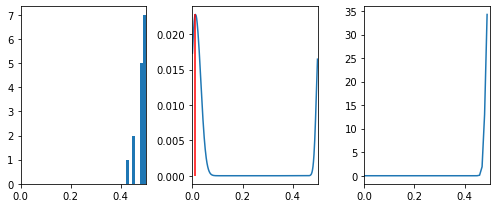

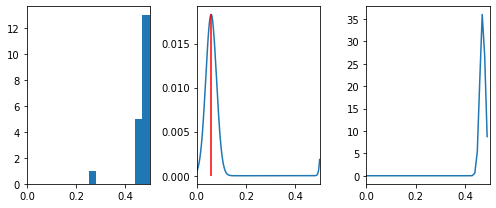

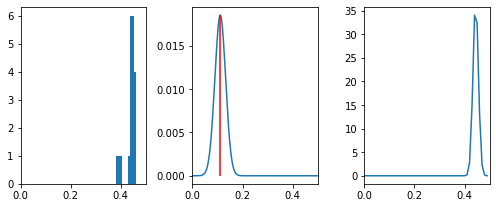

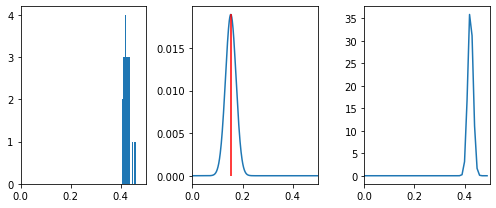

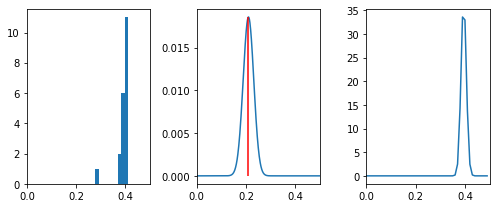

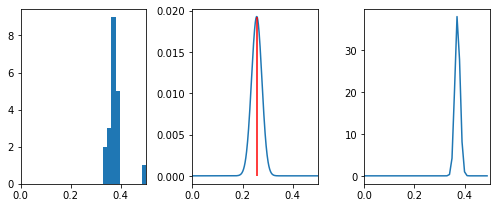

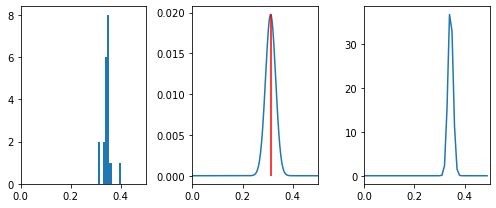

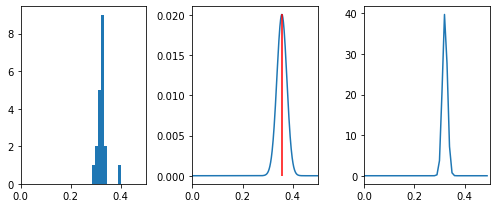

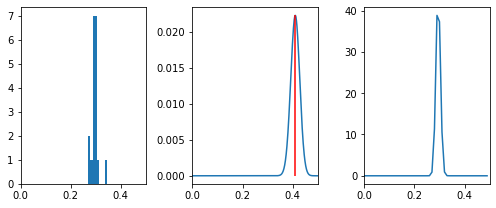

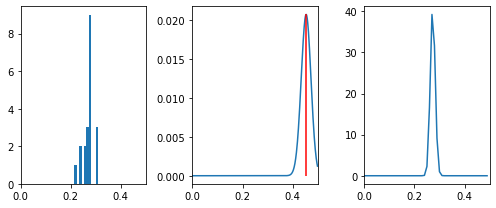

In [181]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        allele1_fraction = total_depth * 0.5
        allele2_depth = total_depth / 2 
        allele2_depth = np.random.normal(loc=allele2_depth * (1-simulated_contam) )

        
        vp.append(
            VariantPosition(total_depth, allele2_depth, 'HET')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    
    plot_result(vp, dist, sorted_likelihoods)